Imports:

In [11]:
import netCDF4 as nc
import datetime as dt
import xarray as xr
import numpy as np
import scipy as sc
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
from scipy import signal
import seaborn as sns

sns.set_style("darkgrid")

Program cells:

In [12]:
dataset_h = xr.open_dataset("Datasets/herdla.nc")
dataset_f  =xr.open_dataset("Datasets/frekhaug.nc")
dataset_m = xr.open_dataset("Datasets/masfjorden.nc")

#pandas method
df_m = pd.DataFrame({"time":dataset_m.time, "value": dataset_m.w_z})
df_m.set_index('time', inplace=True)
binned_data_m = df_m.resample('15T').mean()

df_f = pd.DataFrame({"time":dataset_f.time, "value": dataset_f.w_z})
df_f.set_index('time', inplace=True)
binned_data_f = df_f.resample('15T').mean()

df_h = pd.DataFrame({"time":dataset_h.time, "value": dataset_h.w_z})
df_h.set_index('time', inplace=True)
binned_data_h = df_h.resample('15T').mean()

In [13]:
#Basic calculations

a = round(np.mean(binned_data_f.value), 5)
b = round(np.mean(binned_data_h.value), 5)
c = round(np.mean(binned_data_m.value), 5)
print(a,b,c)

d = np.var(binned_data_f.value, ddof=1)
e = np.var(binned_data_h.value, ddof=1)
f = np.var(binned_data_m.value, ddof=1)
d_fin = "{:.4e}".format(d)
e_fin = "{:.4e}".format(e)
f_fin = "{:.4e}".format(f)
print(d_fin,e_fin,f_fin)

g = np.median(binned_data_f.value[~np.isnan(binned_data_f.value)])
h = np.median(binned_data_h.value)
i = np.median(binned_data_m.value)
print(g,h,i)

9.89326 9.62646 9.68678
2.2976e-05 3.1915e-04 6.1603e-04
9.892852 9.621738 9.679521


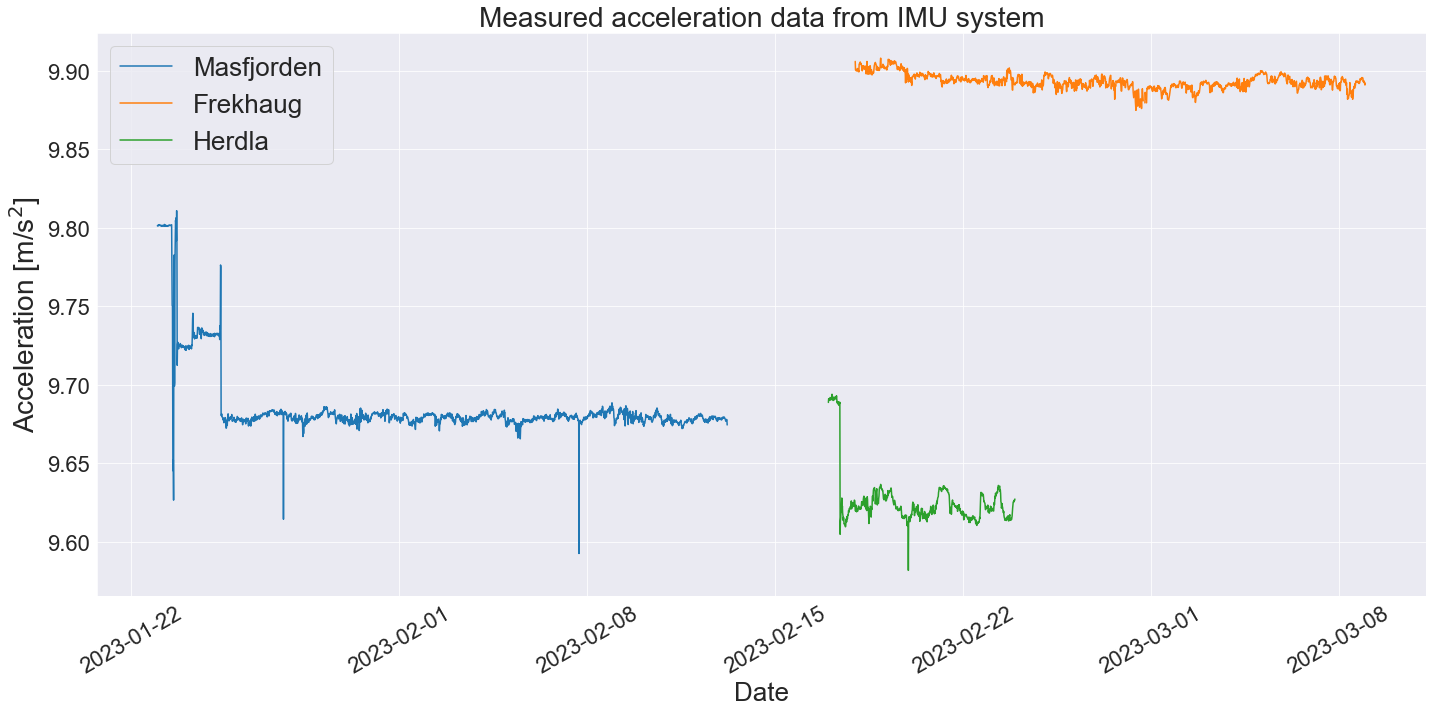

In [14]:
#Overview of all measurements, not including removal of outliers due to previous binning
plt.figure(figsize = (20,10))
plt.plot(binned_data_m, label = "Masfjorden")
plt.plot(binned_data_f, label = "Frekhaug")
plt.plot(binned_data_h, label = "Herdla")
plt.xticks(rotation = 30, fontsize = 22)
plt.yticks(fontsize = 22)
plt.title("Measured acceleration data from IMU system", fontsize = 28)
plt.legend(fontsize = 26)
plt.ylabel("Acceleration [m/s$^2$]", fontsize = 28)
plt.xlabel("Date", fontsize = 26)
plt.tight_layout()
# plt.savefig("measured_acc.pdf", dpi=300)
plt.show()

C:\Users\lepso\AppData\Local\Temp\ipykernel_25980\4101727094.py:20: RuntimeWarning: divide by zero encountered in log
  plt.plot(x, np.exp(-np.log(x*10**2) + np.log(x[-1] * -m_m_acc)), label=f'Linear regression: {m_m_acc}', color="yellowgreen")


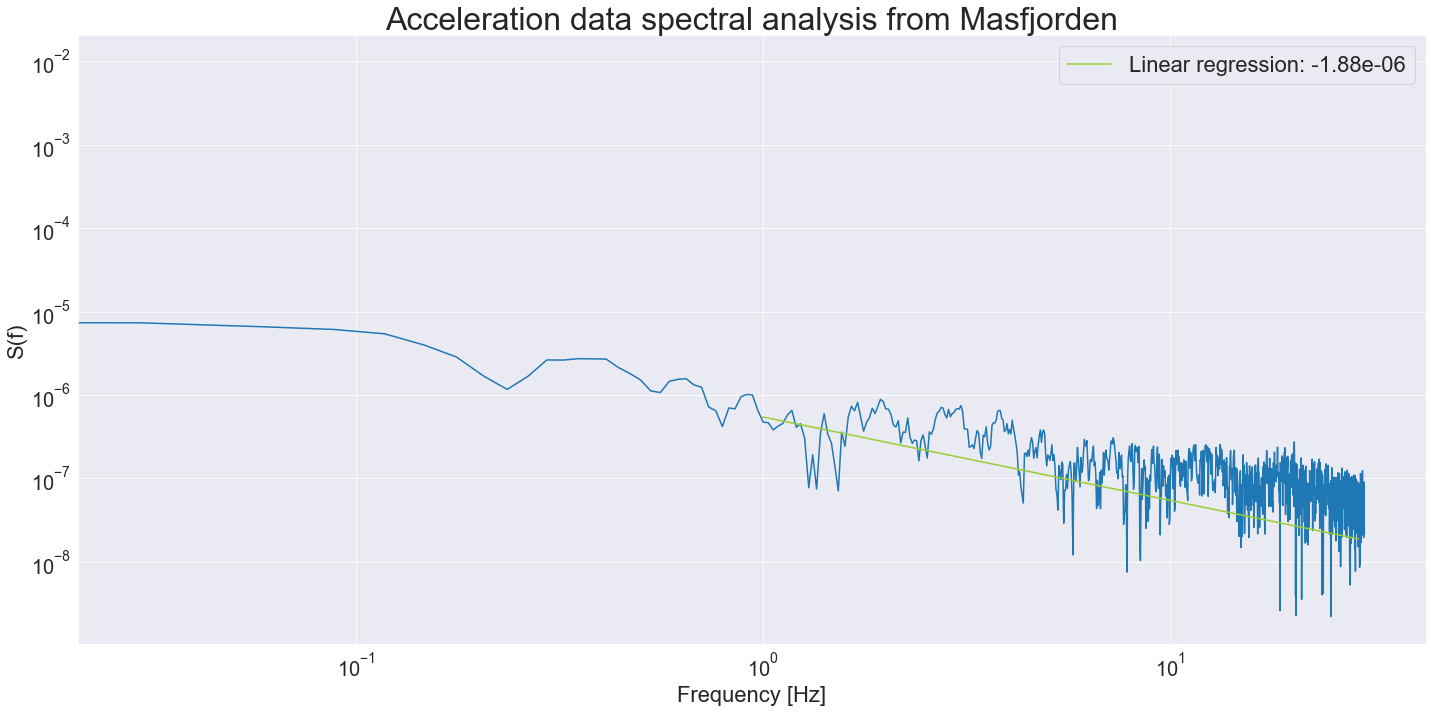

C:\Users\lepso\AppData\Local\Temp\ipykernel_25980\4101727094.py:38: RuntimeWarning: divide by zero encountered in log
  plt.plot(x, np.exp(-np.log(x*10**2) + np.log(x[-1] * -h_m_acc)), label=f'Linear regression: {h_m_acc}', color="yellowgreen")


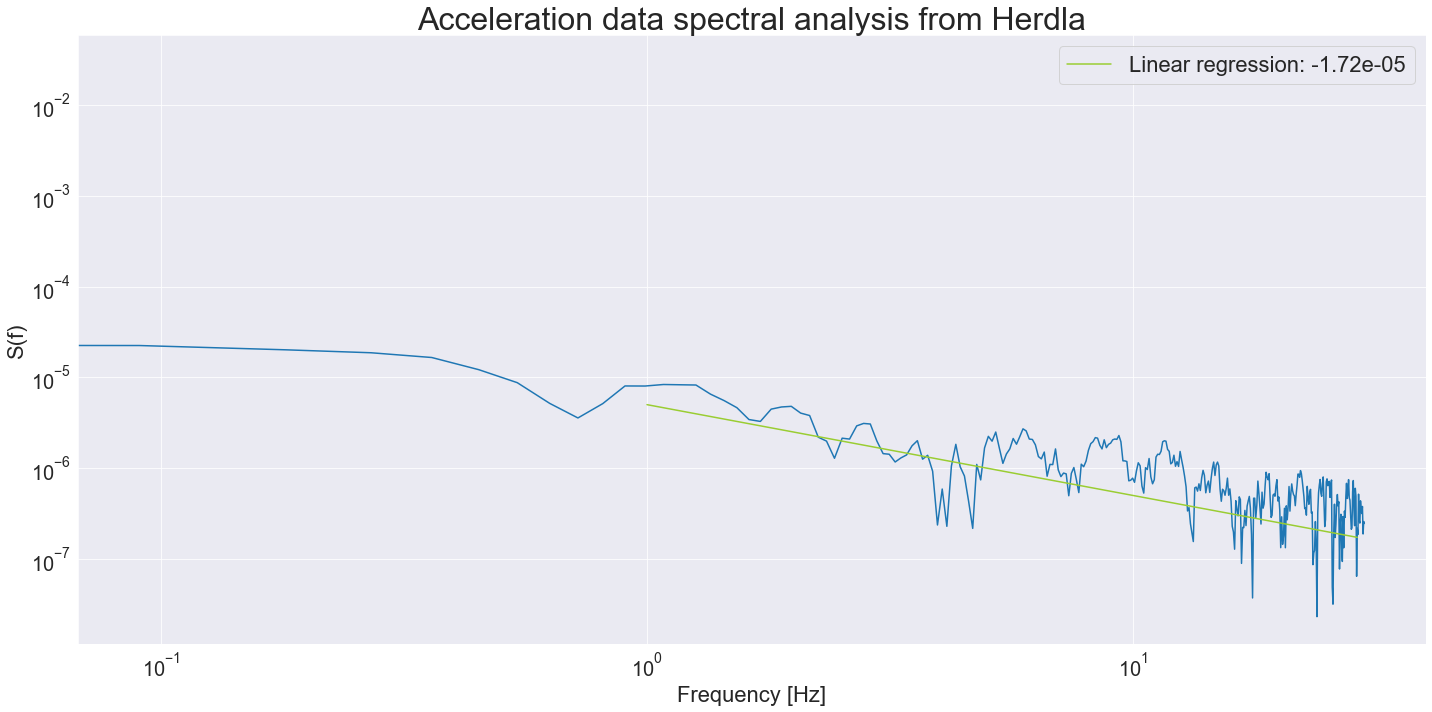

In [15]:
#FFT Spectral density

x = np.arange(0,30)
k = 5/3

def fourier_spectral_density(data, t):
    freq = np.linspace(0, 30, t//2)
    fft_komponent = np.fft.fft(data)/t
    m,b = np.polyfit(freq,2/t * np.abs(fft_komponent[0:t//2]),1)
    m_fin = "{:.2e}".format(m)
    
    return fft_komponent, float(m_fin), freq
    
m_acc, m_m_acc, m_freq = fourier_spectral_density(binned_data_m.value, len(binned_data_m.value))


plt.figure(figsize=(20,10))
plt.plot(m_freq, 2/len(binned_data_m.value) * np.abs(m_acc[0:len(binned_data_m.value)//2]))
# plt.plot(x, np.exp(-np.log(x*10**6) + np.log(x[-1] * k)), label='-5/3', color="red")
plt.plot(x, np.exp(-np.log(x*10**2) + np.log(x[-1] * -m_m_acc)), label=f'Linear regression: {m_m_acc}', color="yellowgreen")
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Frequency [Hz]', fontsize=22)
plt.ylabel('S(f)', fontsize=22)
plt.title('Acceleration data spectral analysis from Masfjorden', fontsize=32)
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.legend(fontsize = 22)
plt.tight_layout()
# plt.savefig('acc_fft.pdf', dpi = 300)
plt.show()

h_acc, h_m_acc, h_freq = fourier_spectral_density(binned_data_h.value, len(binned_data_h.value))

plt.figure(figsize=(20,10))
plt.plot(h_freq, 2/len(binned_data_h.value) * np.abs(m_acc[0:len(binned_data_h.value)//2]))
# plt.plot(x, np.exp(-np.log(x*10**5) + np.log(x[-1] * k)), label='-5/3', color="red")
plt.plot(x, np.exp(-np.log(x*10**2) + np.log(x[-1] * -h_m_acc)), label=f'Linear regression: {h_m_acc}', color="yellowgreen")
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Frequency [Hz]', fontsize=22)
plt.ylabel('S(f)', fontsize=22)
plt.title('Acceleration data spectral analysis from Herdla', fontsize=32)
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.legend(fontsize = 22)
plt.tight_layout()
# plt.savefig('acc_h_fft.pdf', dpi = 300)
plt.show()

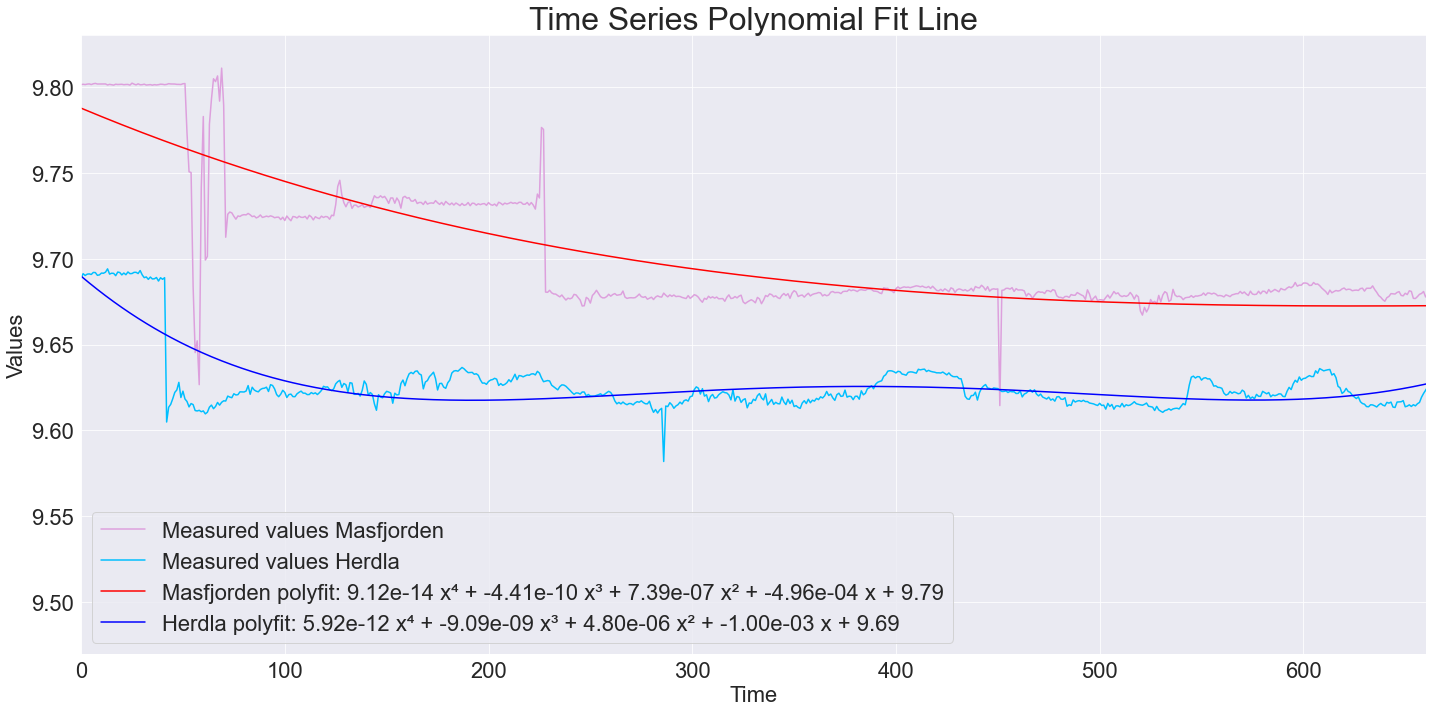

In [16]:
#Polynomial fitted line for observing trends

#Masfjorden
binned_data_m.index = np.arange(len(binned_data_m))
coefficients_m = np.polyfit(binned_data_m.index, binned_data_m.value, 4)
polynomial_m = np.poly1d(coefficients_m)
binned_data_m['polyfit'] = polynomial_m(binned_data_m.index)
formatted_string_m = f"{coefficients_m[0]:.2e} x⁴ + {coefficients_m[1]:.2e} x³ + {coefficients_m[2]:.2e} x² + {coefficients_m[3]:.2e} x + {coefficients_m[4]:.2f}"
a_m = "Masfjorden polyfit: " + formatted_string_m


#Herdla
binned_data_h.index = np.arange(len(binned_data_h))
coefficients_h = np.polyfit(binned_data_h.index, binned_data_h.value, 4)
polynomial_h = np.poly1d(coefficients_h)
binned_data_h['polyfit'] = polynomial_h(binned_data_h.index)
formatted_string_h = f"{coefficients_h[0]:.2e} x⁴ + {coefficients_h[1]:.2e} x³ + {coefficients_h[2]:.2e} x² + {coefficients_h[3]:.2e} x + {coefficients_h[4]:.2f}"
a_h = "Herdla polyfit: " + formatted_string_h


#Plot
plt.figure(figsize=(20, 10))
plt.plot(binned_data_m.value, color='plum', label = "Measured values Masfjorden")
plt.plot(binned_data_h.value, color='deepskyblue', label = "Measured values Herdla")
plt.plot(binned_data_m.polyfit, color='red', label = a_m)
plt.plot(binned_data_h.polyfit, color='blue', label = a_h)
plt.title('Time Series Polynomial Fit Line', fontsize = 32)
plt.xlabel('Time', fontsize = 22)
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
plt.xlim(0, 660)
plt.ylim(9.47, 9.83)
plt.ylabel('Values', fontsize = 22)
plt.legend(loc = "lower left", fontsize = 22)
plt.tight_layout()
# plt.savefig("time_series_polynomial_fit_line.pdf", dpi = 300)
plt.show()

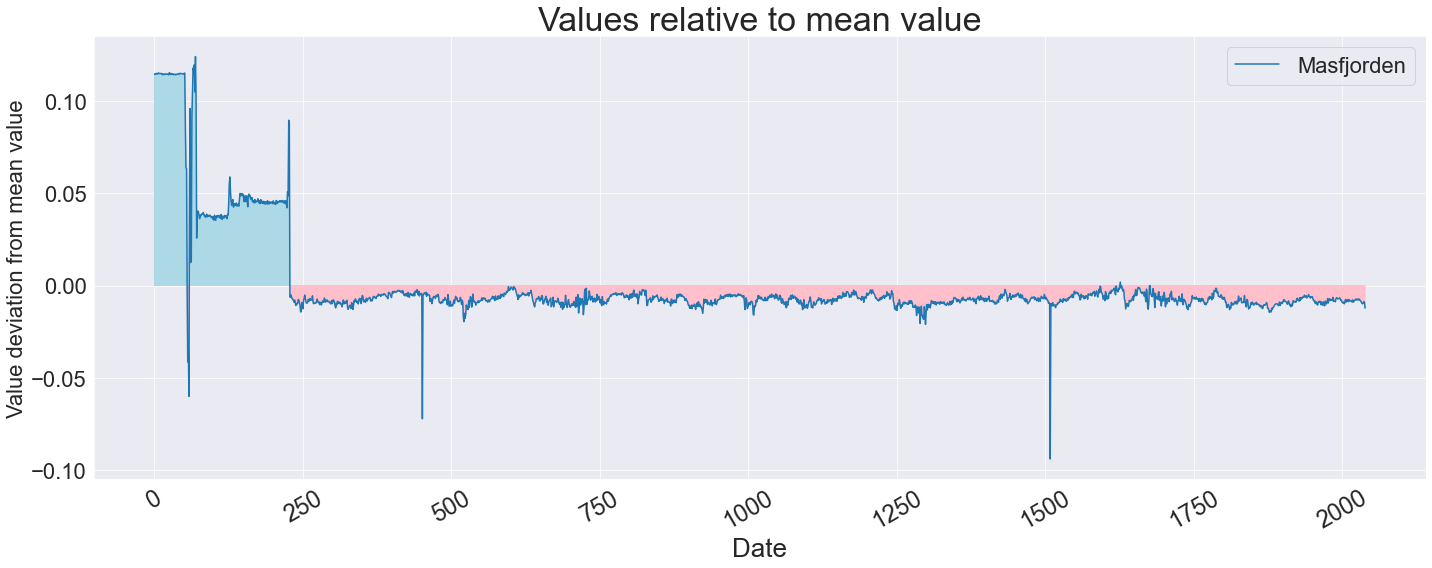

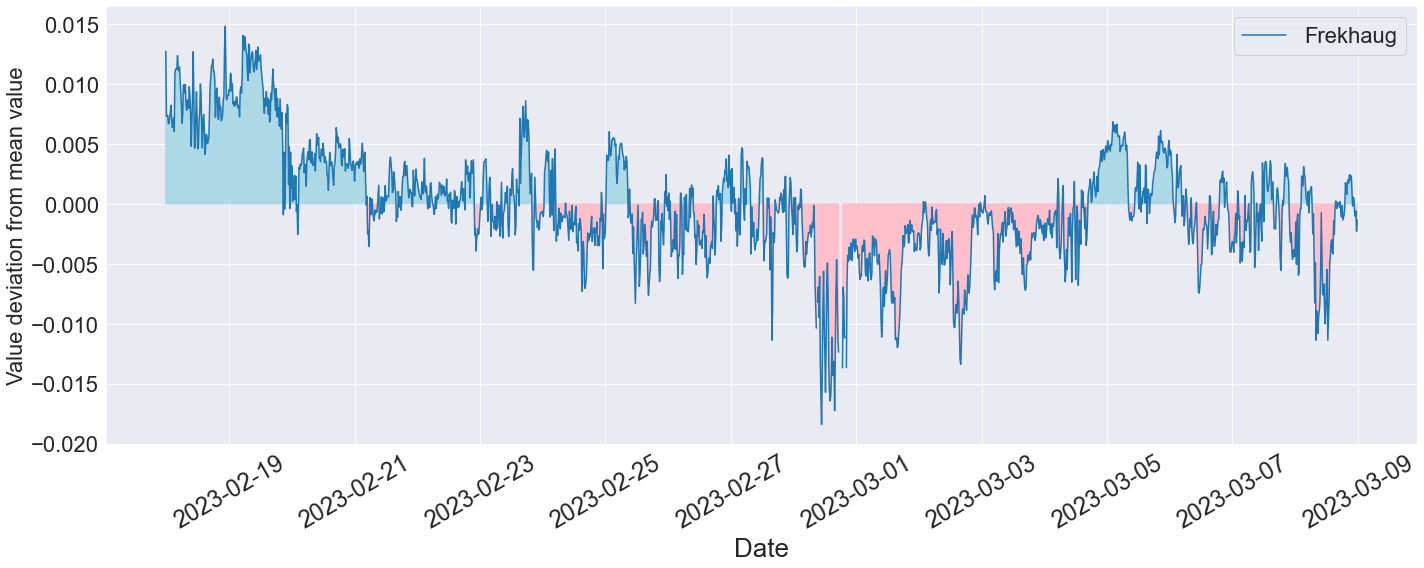

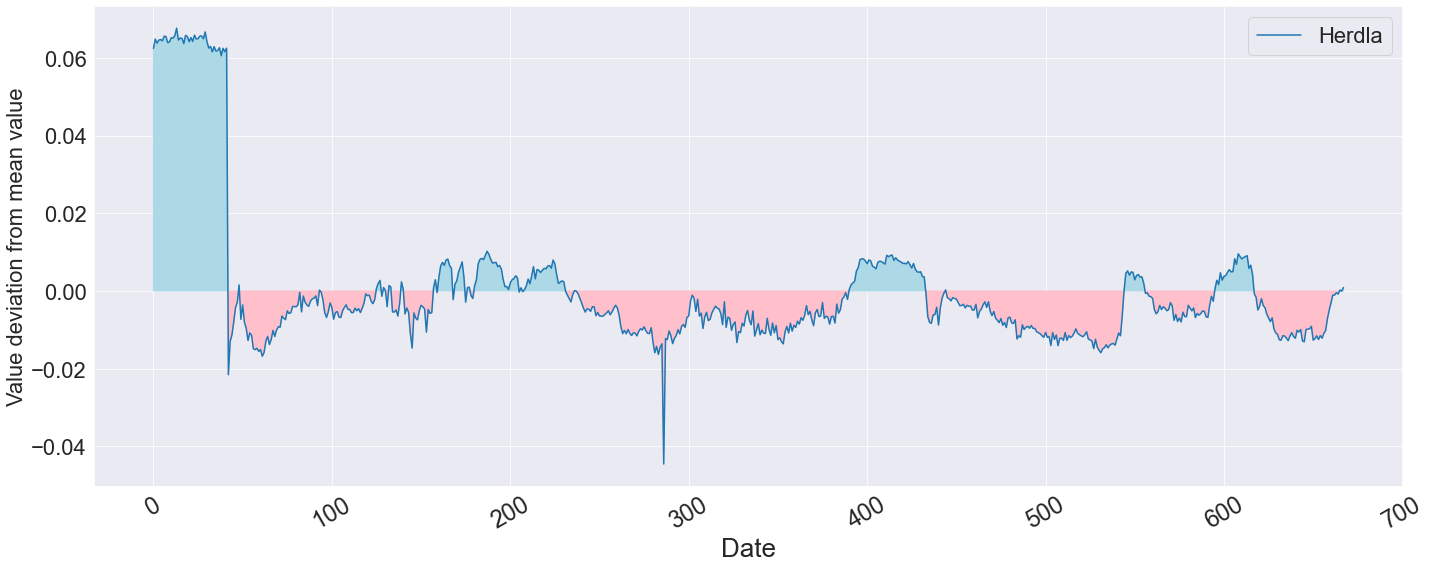

In [17]:
#Values relative to mean value

#Masfjorden
binned_data_m.value = binned_data_m.value - np.mean(binned_data_m.value)
plt.figure(figsize=(20, 8))
plt.plot(binned_data_m.value, label = "Masfjorden")
# plt.show()
plt.fill_between(binned_data_m.index, binned_data_m.value, where=(binned_data_m.value > 0), color='lightblue', interpolate=True) # For values above 0
plt.fill_between(binned_data_m.index, binned_data_m.value, where=(binned_data_m.value < 0), color='pink', interpolate=True) # For values below 0
plt.title("Values relative to mean value", fontsize = 34)
plt.xlabel("Date", fontsize = 26)
plt.xticks(rotation = 30, fontsize = 24)
plt.ylabel("Value deviation from mean value", fontsize = 22)
plt.yticks(fontsize = 22)
plt.legend(fontsize = 22)
plt.tight_layout()
# plt.savefig("values_rel_to_mean_M.pdf", dpi = 300)
plt.show()

#Frekhaug
binned_data_f.value = binned_data_f.value - np.mean(binned_data_f.value)
plt.figure(figsize=(20, 8))
plt.plot(binned_data_f.value, label = "Frekhaug")
# plt.show()
plt.fill_between(binned_data_f.index, binned_data_f.value, where=(binned_data_f.value > 0), color='lightblue', interpolate=True) # For values above 0
plt.fill_between(binned_data_f.index, binned_data_f.value, where=(binned_data_f.value < 0), color='pink', interpolate=True) # For values below 0
# plt.title("Values relative to mean value", fontsize = 28)
plt.xlabel("Date", fontsize = 26)
plt.xticks(rotation = 30, fontsize = 24)
plt.ylabel("Value deviation from mean value", fontsize = 22)
plt.yticks(fontsize = 22)
plt.legend(fontsize = 22)
plt.tight_layout()
# plt.savefig("values_rel_to_mean_F.pdf", dpi = 300)
plt.show()

#Herdla
binned_data_h.value = binned_data_h.value - np.mean(binned_data_h.value)
plt.figure(figsize=(20, 8))
plt.plot(binned_data_h.value, label = "Herdla")
# plt.show()
plt.fill_between(binned_data_h.index, binned_data_h.value, where=(binned_data_h.value > 0), color='lightblue', interpolate=True) # For values above 0
plt.fill_between(binned_data_h.index, binned_data_h.value, where=(binned_data_h.value < 0), color='pink', interpolate=True) # For values below 0
# plt.title("Values relative to mean value", fontsize = 28)
plt.xlabel("Date", fontsize = 26)
plt.xticks(rotation = 30, fontsize = 24)
plt.ylabel("Value deviation from mean value", fontsize = 22)
plt.yticks(fontsize = 22)
plt.legend(fontsize = 22)
plt.tight_layout()
# plt.savefig("values_rel_to_mean_H.pdf", dpi = 300)
plt.show()